In [2]:
"""\
# Copyright (C) 2023 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 --version

# From Google Colab
#!git clone https://github.com/jesusBV20/multi_C3BF.git
#!rsync -a multi_C3BF/ .
#!rm -r multi_C3BF

Python 3.11.2


In [115]:
# ----------------------------------------------------------------------
# Importamos las librerías principales
# ----------------------------------------------------------------------

import os
import numpy as np
from numpy import linalg as LA
from tqdm import tqdm

# Para graficar
import matplotlib.pyplot as plt
from seaborn import color_palette

# Para animar y visualizar animaciones
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

# QP solvers
#!pip install qpsolvers
#from qpsolvers import solve_qp

# ----------------------------------------------------------------------
# CBF_tools
# ----------------------------------------------------------------------

# Toolbox
from simulations.utils.toolbox import unicycle_patch, fmt_data_axis, cone_params, createDir

# GVF + CBF simulator
from simulations.utils.simulator import simulator

# GVF trajectories
from simulations.gvf_traj.gvf_traj_ellipse  import gvf_ellipse

E = np.array([[0, 1],[-1, 0]])

---
## Paper figures
---

### C3BF notation


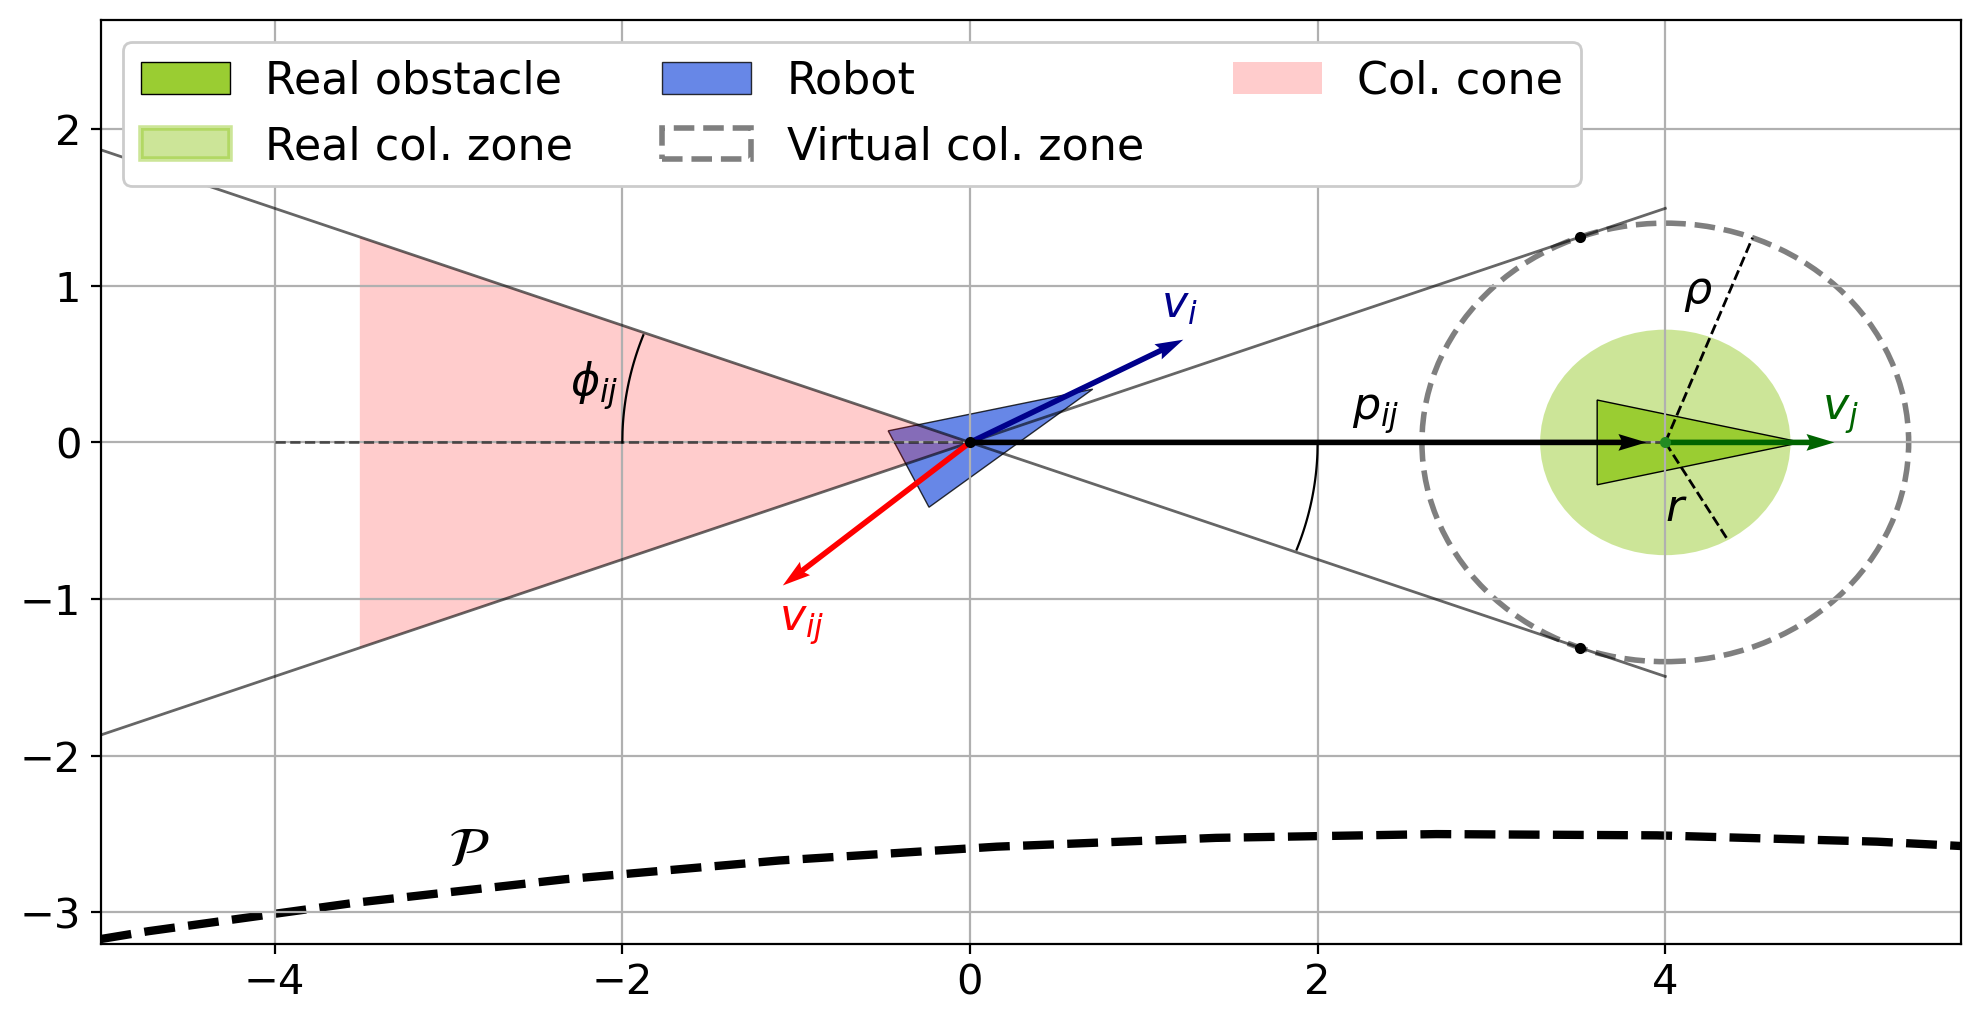

In [52]:
# ----------------------------
# C3BF - Notation plot
# ----------------------------

# Parameters
col_rad = 1.4

rbt_xy = np.array([0, 0])
obs_xy = np.array([4, 0])
rbt_phi = np.pi/7
obs_phi = 0

# Trajectory (just to draw it)
gvf_traj = gvf_ellipse([3,-10.5],0,20,8)

# ----------------------------------------------
# Inicialización y configuración de la figuras
fig = plt.figure(figsize = (12, 6), dpi = 200)
ax = fig.subplots()

ax.set_xlim([-6+1,4.7+1]) ################
ax.set_ylim([-3.2,2.7]) ############

ax.tick_params(axis='both', labelsize=15)
ax.grid(True)

# Draw the trajectory
gvf_traj.draw(fig, ax, draw_field=False, lw=3)

# Draw the robot
icon_rbt = unicycle_patch(rbt_xy, rbt_phi, "royalblue")
icon_rbt.set_alpha(0.8)
icon_rbt.set_label("Robot")

# Draw the obstacle
icon_obs = unicycle_patch(obs_xy, obs_phi, "yellowgreen")
icon_col = patches.Circle(obs_xy, col_rad, alpha=0.5, fill=False,
                          color="k", ls="--", lw=2)
icon_col_real = patches.Circle(obs_xy, 0.72, alpha=0.5, fill=True,
                               color="yellowgreen", ls="", lw=2, zorder=-1)
ax.add_patch(icon_obs)
ax.add_patch(icon_col_real)
ax.add_patch(icon_rbt)
ax.add_patch(icon_col)


# Draw the collision cone
P, K = cone_params(obs_xy, col_rad, rbt_xy)
I, H = cone_params(-obs_xy, col_rad, rbt_xy)

cone = patches.Polygon(np.array([rbt_xy, I, H]), alpha=0.2,
                       color="red", zorder=1, lw=0)
ax.add_patch(cone)

# Draw the points
pts = np.array([[0,0],P,K])
ax.plot(pts[:,0], pts[:,1], ".k", zorder=3)
ax.plot(obs_xy[0], obs_xy[1], ".", c="forestgreen", zorder=4)

# Draw the lines
x_draw  = np.linspace(-5,4,100)
x_draw2 = np.linspace(-4,0,100)

ax.plot(x_draw, (K[1]-H[1])/(K[0]-H[0])*x_draw, "-k", lw=1, alpha=0.6)
ax.plot(x_draw, (P[1]-I[1])/(P[0]-I[0])*x_draw, "-k", lw=1, alpha=0.6)
ax.plot( x_draw2, 0*x_draw2, "--k", lw=1, alpha=0.6)
ax.plot(-x_draw2, 0*x_draw2, "--k", lw=1, alpha=0.6)
ax.plot([obs_xy[0], obs_xy[0] + col_rad*np.cos(2.3*np.pi/6)], 
        [obs_xy[1], obs_xy[1] + col_rad*np.sin(2.3*np.pi/6)], "--k", lw=1, alpha=1)
ax.plot([obs_xy[0], obs_xy[0] + 0.72*np.cos(5*np.pi/3)], 
        [obs_xy[1], obs_xy[1] + 0.72*np.sin(5*np.pi/3)], c="k", ls="--", lw=1, alpha=1)

# Draw every important vector
arr_kw = {"width":0.003, "scale":11, "zorder":2}

v_rel_x = (np.cos(obs_phi) - 3*np.cos(rbt_phi))/2
v_rel_y = (np.sin(obs_phi) - 3*np.sin(rbt_phi))/2
ax.quiver(rbt_xy[0], rbt_xy[1], v_rel_x*1.3, v_rel_y*1.3, color="red", **arr_kw)
ax.quiver(rbt_xy[0], rbt_xy[1], np.cos(rbt_phi)*1.4, np.sin(rbt_phi)*1.4, color="darkblue", **arr_kw)
ax.quiver(obs_xy[0], obs_xy[1], np.cos(obs_phi)/1, np.sin(obs_phi)/1, color="darkgreen", **arr_kw)
ax.quiver(rbt_xy[0], rbt_xy[1], 4, 0, color="k", **arr_kw)

# Draw arcs
r = 2
x_arc1 = np.linspace(-r, -r*np.cos(np.pi/9), 100)
x_arc2 = np.linspace(r*np.cos(np.pi/9), r , 100)

ax.plot(x_arc1,  np.sqrt(r**2 - x_arc1**2), "-k", lw=0.8)
ax.plot(x_arc2, -np.sqrt(r**2 - x_arc2**2), "-k", lw=0.8)

# Draw the text boxes
ax.text(-2.3,0.3, r"$\phi_{ij}$",  fontsize=16)
ax.text(4.1, 0.89, r"$\rho$", fontsize=16)
ax.text(4, -0.5, r"$r$", c="k", fontsize=16)

# ax.text(-0.38,-0.9, r"$(X_i,Y_i)$", fontsize=17)
# ax.text(-4.4,-0.9, r"$(X_j,Y_j)$", fontsize=17)

ax.text(-1.1, -1.2, r"$v_{ij}$", c="red", fontsize=16)
ax.text(2.2, 0.15, r"$p_{ij}$", fontsize=16)

ax.text(1.1, 0.8, r"$v_{i}$", c="darkblue", fontsize=16)
ax.text(4.9, 0.15, r"$v_{j}$", c="darkgreen", fontsize=16)

ax.text(-3,-2.7, r"$\mathcal{P}$", c="k", fontsize=20)

# Legend
icon_obs.set_label("Real obstacle")
icon_col_real.set_label("Real col. zone")
icon_col.set_label("Virtual col. zone")
cone.set_label("Col. cone")
plt.legend(loc="upper left", ncol=3, fancybox=True, framealpha=1, fontsize=16)

# plot
plt.show()

### Assumption 1

In [164]:
# Parameters
col_rad = 1.4

rbt_xy = np.array([[-6, 1], [-2.5, -1.5], [0.6,1.5]])
rbt_phi = np.array([np.pi/4, np.pi/7, np.pi/10])

obs_xy = np.array([3, 0])
obs_phi = 0

a, b, xoff = 20, 8, [3,-10]

# Drawing parameters
r_arc = 1.4

1.4 (3, 2)


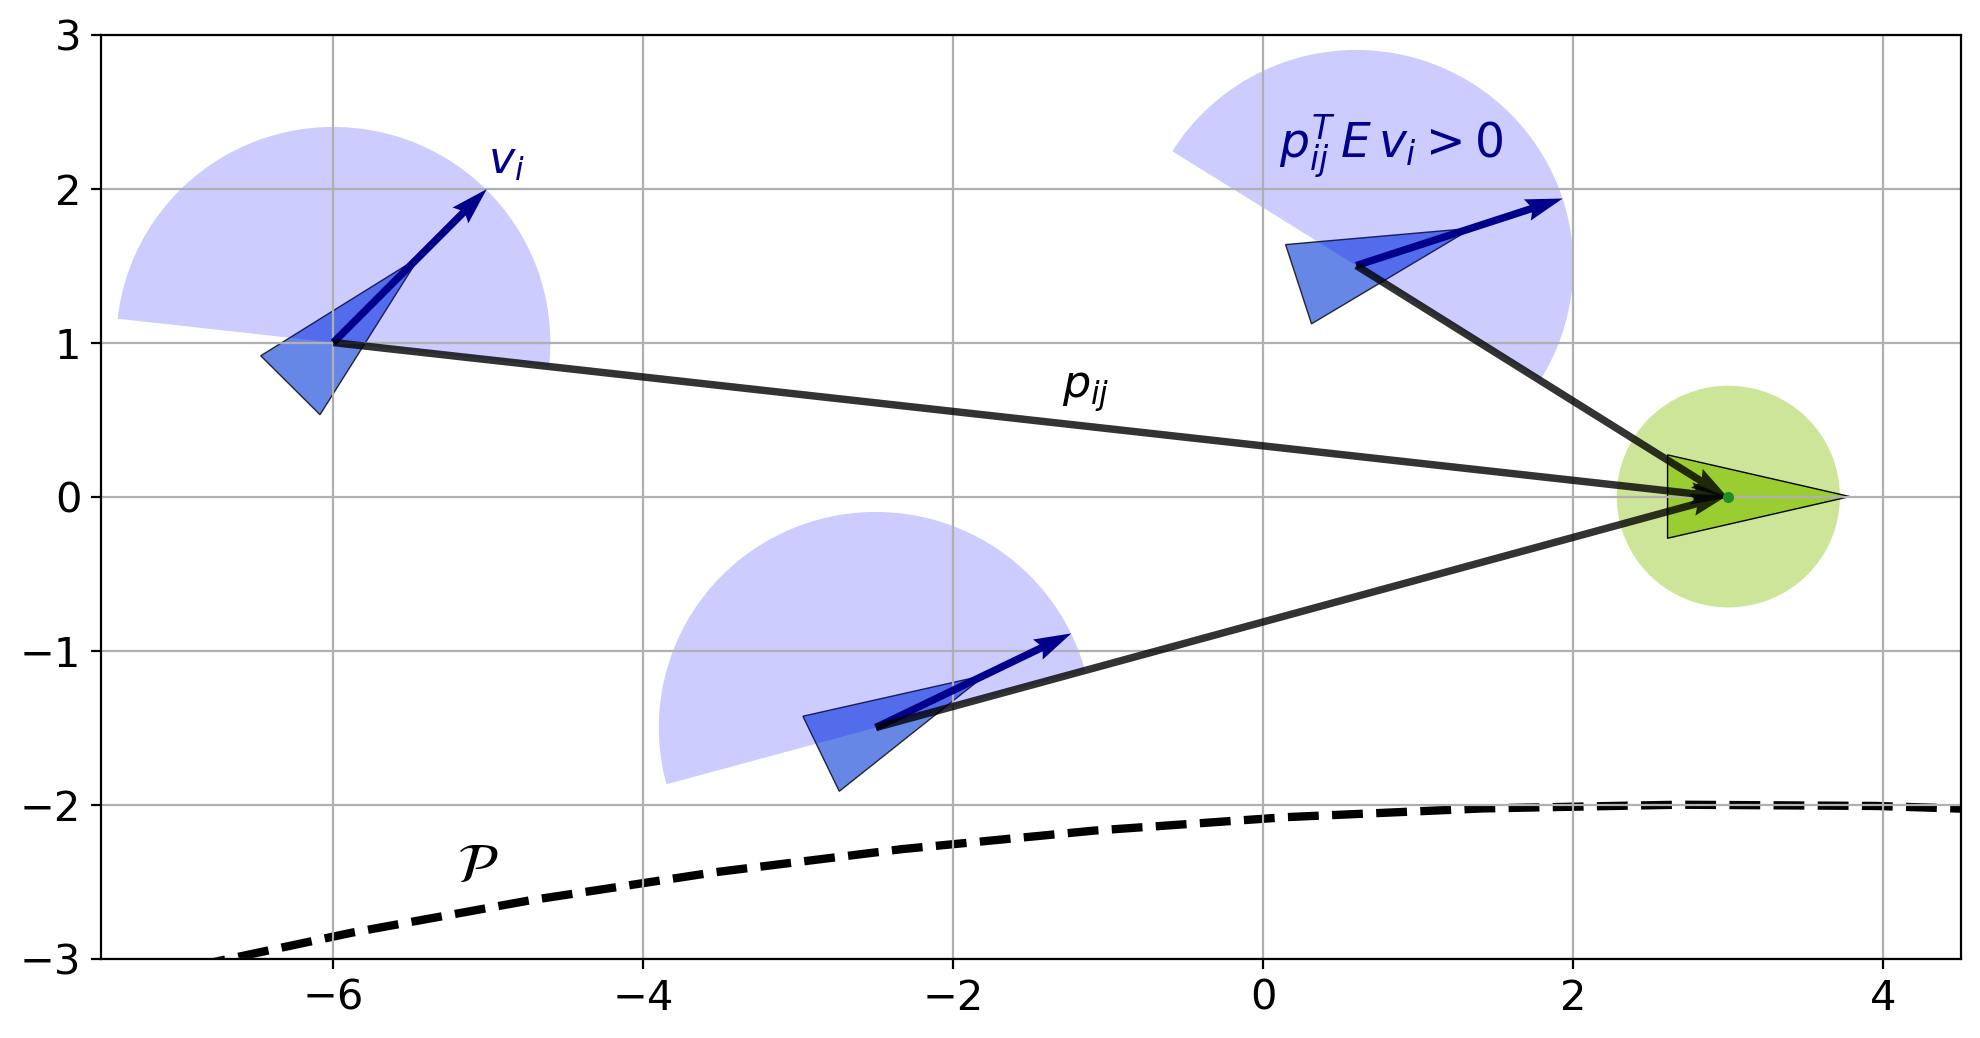

In [226]:
# ----------------------------
# C3BF - Notation plot
# ----------------------------

n = rbt_xy.shape[0]

# Trajectory (just to draw it)
gvf_traj = gvf_ellipse(xoff,0,a,b)

# ----------------------------------------------
# Inicialización y configuración de la figuras
fig = plt.figure(figsize = (12, 6), dpi = 200)
ax = fig.subplots()

ax.set_xlim([-7.5,4.5]) ################
ax.set_ylim([-3,3]) ############

ax.tick_params(axis='both', labelsize=15)
ax.grid(True)

# Draw the trajectory
gvf_traj.draw(fig, ax, draw_field=False, lw=3)

# Draw the obstacle
icon_obs = unicycle_patch(obs_xy, obs_phi, "yellowgreen")
icon_col_real = patches.Circle(obs_xy, 0.72, alpha=0.5, fill=True,
                               color="yellowgreen", ls="", lw=2, zorder=-1)
ax.add_patch(icon_obs)
ax.add_patch(icon_col_real)

# Draw the points
ax.plot(obs_xy[0], obs_xy[1], ".", c="forestgreen", zorder=4)

# Draw the lines
# x_draw  = np.linspace(-5,4,100)
# x_draw2 = np.linspace(-4,0,100)

# ax.plot( x_draw2, 0*x_draw2, "--k", lw=1, alpha=0.6)
# ax.plot(-x_draw2, 0*x_draw2, "--k", lw=1, alpha=0.6)

for i in range(n):
        # Draw the robot
        icon_rbt = unicycle_patch(rbt_xy[i,:], rbt_phi[i], "royalblue")
        icon_rbt.set_alpha(0.8)
        ax.add_patch(icon_rbt)
        
        # Draw level set
        # phi = np.sqrt(gvf_traj.phi(rbt_xy[i,:])[0]) + 1
        # level_set = gvf_ellipse(xoff,0,a + phi,b + phi)
        # level_set.draw(fig, ax, draw_field=False, lw=3, alpha=0.5)

        # Draw every important vector
        arr_kw = {"width":0.004, "scale":12, "zorder":2}

        v_rel_x = (np.cos(obs_phi) - 3*np.cos(rbt_phi[i]))/2
        v_rel_y = (np.sin(obs_phi) - 3*np.sin(rbt_phi[i]))/2
        ax.quiver(rbt_xy[i,0], rbt_xy[i,1], np.cos(rbt_phi[i])*1.4, np.sin(rbt_phi[i])*1.4, color="darkblue", **arr_kw)
        ax.quiver(rbt_xy[i,0], rbt_xy[i,1], obs_xy[0]-rbt_xy[i,0], obs_xy[1]-rbt_xy[i,1], color="k", **arr_kw, alpha=0.8)

        # Draw the blue shape
        t_i = np.arctan2((obs_xy[1]-rbt_xy[i,1]), (obs_xy[0]-rbt_xy[i,0]))
        t = np.linspace(t_i, t_i+np.pi, 200)
        xr, yr = rbt_xy[i,0] + r_arc*np.cos(t), rbt_xy[i,1] + r_arc*np.sin(t)
        ax.fill(xr, yr, c="blue", alpha=0.2, lw=0)

# Draw the text boxes
ax.text(-1.3, 0.65, r"$p_{ij}$", fontsize=16)
ax.text(rbt_xy[0,0]+1, rbt_xy[0,1]+1.1, r"$v_{i}$", c="darkblue", fontsize=16)
ax.text(rbt_xy[2,0]-0.5, rbt_xy[2,1]+0.7, r"$p_{ij}^T \, E \, v_i > 0$", c="darkblue", fontsize=17)
ax.text(-5.2,-2.5, r"$\mathcal{P}$", c="k", fontsize=20)

# Plot
plt.show()

### Overtaking rule

#### Simulation

In [3]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 32**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.01 * 1000
t_sim_final = 50 * 1000

# Constantes de los controladores
ke = 3
kn = 2

r = 1.5
gamma = 1

d = 0.7
rho = lambda prel, k: (np.sqrt(prel.T@prel)**(d)/r**(d-1))
rho_dot = lambda prel, vrel, k: (d * np.sqrt(prel.T@prel)**(d-1)/r**(d - 1) \
                                    * prel.T@vrel/np.sqrt(prel.T@prel))

# Estado inicial de los agentes y número de agentes
n_agents = 2
p0 = np.array([[0, -7.1], [0, 7.1]])
v0 =  np.array([[2.2,0.6]]).T
phi0 = np.pi - np.array([0, -np.pi])

x0 = [p0, v0, phi0]

In [4]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj, n_agents, x0, dt, rho=rho, rho_dot=rho_dot)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
phidata = []
preldata = []
vreldata = []
lghdata = []
lghdata_psi = []
prelvi = []
vjevi = []
psi = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)
    preldata.append(sim.p_rel)
    vreldata.append(sim.v_rel)
    lghdata.append(sim.lgh_all)
    lghdata_psi.append(sim.lgh)
    prelvi.append(sim.prelvi)
    vjevi.append(sim.vjevi)
    psi.append(sim.psi)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

preldata = np.array(preldata)
vreldata = np.array(vreldata)
lghdata = np.array(lghdata)
lghdata_psi = np.array(lghdata_psi)
prelvi = np.array(prelvi)
vjevi = np.array(vjevi)
psi = np.array(psi)

#### Plot

In [98]:
arr_kw = {"width":0.004, "scale":30, "zorder":2, "alpha":0.9}
color_plt = [color_palette()[0], "yellowgreen"]
rbt_labels = [r"Robot $i$", r"Obstacle $j$", r"Col. cone"]

t_list1 = np.array([0, 16]) * 1000
t_list2 = np.array([17.7, 21.2, 36.5]) * 1000

PX_LIMS = [-15,15]
PY_LIMS = [-9.5,9]

figsize = np.array([30, 12])/1.5
dpi=100

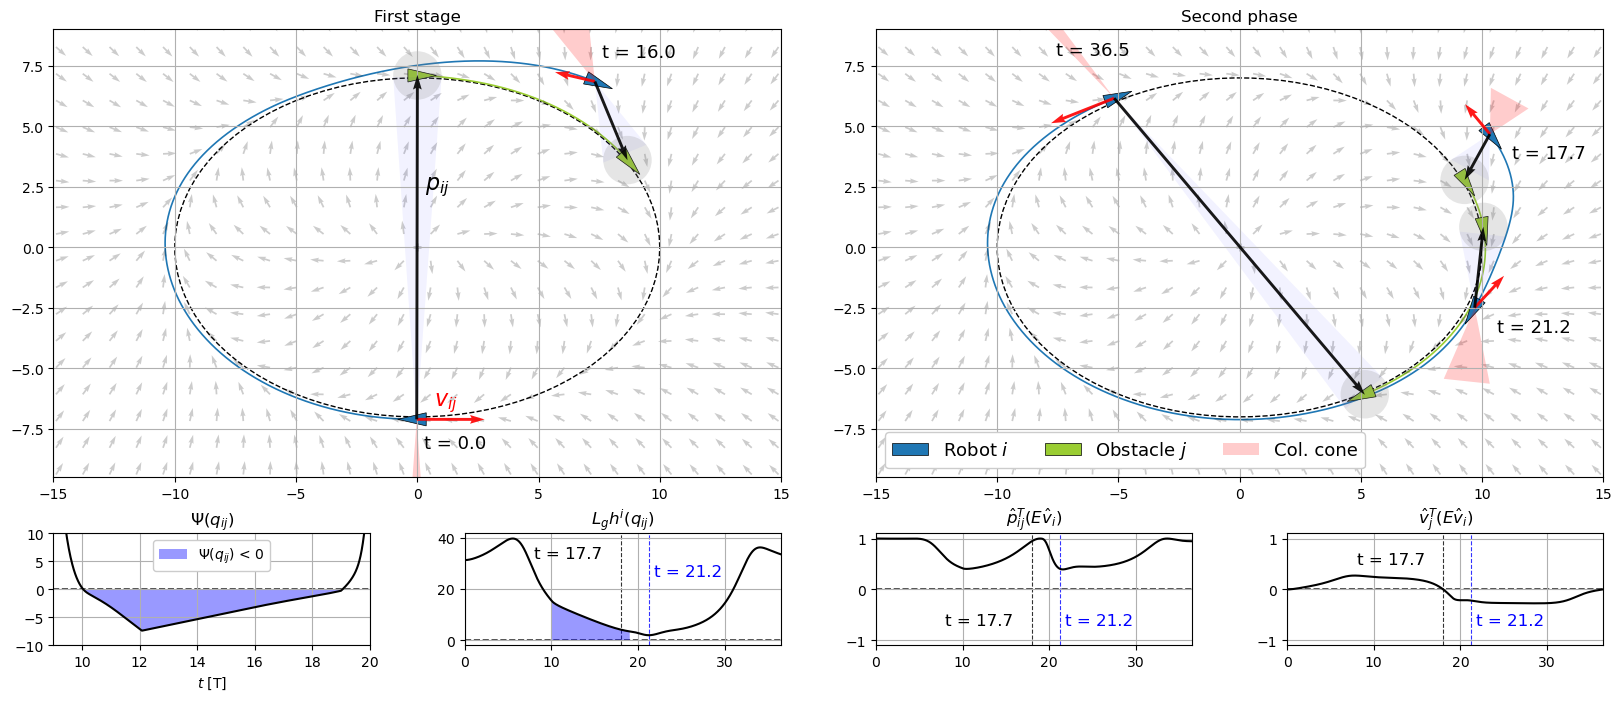

In [99]:
# Interactive visualization desactivated
%matplotlib inline

# ----------------------------------------------------------------------
# (static plot)
# ----------------------------------------------------------------------

ti1, tf1 = t_list1[0], t_list1[-1]
li1, lf1 = int(ti1/dt), int(tf1/dt)
ti2, tf2 = t_list2[0], t_list2[-1]
li2, lf2 = int(ti2/dt), int(tf2/dt)

ti, tf = t_list1[0], t_list2[-1]
li, lf = int(ti/dt), int(tf/dt)

# Init figure and grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.3)

# Init the axis
main_ax  = fig.add_subplot(grid[0:3,0:2])
main_ax2  = fig.add_subplot(grid[0:3,2:4])

data_ax0 = fig.add_subplot(grid[3:4,0])
data_ax  = fig.add_subplot(grid[3:4,1])
data_ax2 = fig.add_subplot(grid[3:4,2])
data_ax3 = fig.add_subplot(grid[3:4,3])

# Format of the axis
main_ax.set_title(r"First phase")
main_ax.set_xlim(PX_LIMS)
main_ax.set_ylim(PY_LIMS)
main_ax.grid(True)

main_ax2.set_title(r"Second phase")
main_ax2.set_xlim(PX_LIMS)
main_ax2.set_ylim(PY_LIMS)
main_ax2.grid(True)

data_ax0.set_xlim([9,20])
data_ax0.set_ylim([-10,10])
data_ax0.set_xlabel(r"$t$ [T]")
data_ax0.set_title(r"$\Psi(q_{ij})$")
data_ax0.grid(True)

data_ax.set_xlim([ti/1000,tf/1000])
data_ax.set_title(r"$L_gh^i (q_{ij})$")
data_ax.grid(True)

data_ax2.set_xlim([ti/1000,tf/1000])
data_ax2.set_ylim([-1.1,1.1])
data_ax2.set_title(r"$\hat p_{ij}^T (E \hat v_i)$")
data_ax2.grid(True)

data_ax3.set_xlim([ti/1000,tf/1000])
data_ax3.set_ylim([-1.1,1.1])
data_ax3.set_title(r"$\hat v_j^T (E \hat v_i)$")
data_ax3.grid(True)

"""\
## Main axis 1 ---------
"""
gvf_traj.draw(fig, main_ax)

for t in t_list1:
    lt = int(t/dt)

    p_obs, p_rbt = [xdata[lt,1], ydata[lt,1]], [xdata[lt,0], ydata[lt,0]]
    p_rel = np.array(p_obs) - np.array(p_rbt)

    # Icon
    for n in range(sim.N):
      color = color_plt[n] # color
      icon = unicycle_patch([xdata[lt,n], ydata[lt,n]], phidata[lt,n], color)
      main_ax.add_patch(icon)

    # BLUE CONES
    p1, p2 = cone_params(p_obs, r, p_rbt)
    cone = patches.Polygon(np.array([p_rbt, p1, p2]),
                          alpha=0.05, color="blue", zorder=1, lw=0)
    main_ax.add_patch(cone)

    # RED CONE
    p1, p2 = cone_params(p_obs - 2*p_rel, r, p_rbt)
    cone = patches.Polygon(np.array([p_rbt, p1, p2]),
                          alpha=0.2, color="red", zorder=1, lw=0)
    main_ax.add_patch(cone)

    # Drawing vectors
    v_obs, v_rbt = v0[1], v0[0]
    phi_rbt = phidata[lt,0]
    phi_obs = phidata[lt,1]
    v_rel = (v_obs*np.array([np.cos(phi_obs), np.sin(phi_obs)]) - \
             v_rbt*np.array([np.cos(phi_rbt), np.sin(phi_rbt)]) )

    main_ax.quiver(p_rbt[0], p_rbt[1], v_rel[0], v_rel[1], **arr_kw, color="red")
    main_ax.quiver(p_rbt[0], p_rbt[1], p_rel[0], p_rel[1], **arr_kw, color="k")

    # Text
    if p_rbt[1] > 0:
      main_ax.text(p_rbt[0]+0.3, p_rbt[1]+1, "t = {0:.1f}".format(t/1000), fontsize=13)
    else:
      main_ax.text(p_rbt[0]+0.3, p_rbt[1]-1.2, "t = {0:.1f}".format(t/1000), fontsize=13)

    # Virtual collision zone
    icon_col = patches.Circle(p_obs, r, alpha=0.2, fill=True,
                              color="gray", ls="-", lw=0)
    main_ax.add_patch(icon_col)

# Trace
for n in range(sim.N):
  color = color_plt[n] # color
  main_ax.plot(xdata[li1:lf1,n], ydata[li1:lf1,n], c=color, ls="-", lw=1.2, zorder=0)

# Text
main_ax.text(0.3, 2.4, r"$p_{ij}$", c="k"  , fontsize=16)
main_ax.text(0.7, -6.5,  r"$v_{ij}$", c="red", fontsize=16)


"""\
## Main axis 2 ---------
"""
gvf_traj.draw(fig, main_ax2)

main_ax.set_title(r"First stage")
for t in t_list2:
    lt = int(t/dt)

    p_obs, p_rbt = [xdata[lt,1], ydata[lt,1]], [xdata[lt,0], ydata[lt,0]]
    p_rel = np.array(p_obs) - np.array(p_rbt)

    # Icon
    for n in range(sim.N):
      color = color_plt[n] # color
      icon = unicycle_patch([xdata[lt,n], ydata[lt,n]], phidata[lt,n], color)
      main_ax2.add_patch(icon)
      if t == t_list2[0]:
        icon.set_label(rbt_labels[n])
        
    # BLUE CONES
    p1, p2 = cone_params(p_obs, r, p_rbt)
    cone = patches.Polygon(np.array([p_rbt, p1, p2]),
                          alpha=0.05, color="blue", zorder=1, lw=0)
    main_ax2.add_patch(cone)

    # RED CONE
    p1, p2 = cone_params(p_obs - 2*p_rel, r, p_rbt)
    cone = patches.Polygon(np.array([p_rbt, p1, p2]),
                          alpha=0.2, color="red", zorder=1, lw=0)
    main_ax2.add_patch(cone)
    if t == t_list2[0]:
      cone.set_label(rbt_labels[2])

    # Drawing vectors
    v_obs, v_rbt = v0[1], v0[0]
    phi_rbt = phidata[lt,0]
    phi_obs = phidata[lt,1]
    v_rel = (v_obs*np.array([np.cos(phi_obs), np.sin(phi_obs)]) - \
             v_rbt*np.array([np.cos(phi_rbt), np.sin(phi_rbt)]) )

    main_ax2.quiver(p_rbt[0], p_rbt[1], v_rel[0], v_rel[1], **arr_kw, color="red")
    main_ax2.quiver(p_rbt[0], p_rbt[1], p_rel[0], p_rel[1], **arr_kw, color="k")

    # Text
    if p_rbt[0] > 0:
      main_ax2.text(p_rbt[0]+0.9, p_rbt[1]-1, "t = {0:.1f}".format(t/1000), fontsize=13)
    else:
      main_ax2.text(p_rbt[0]-2.4, p_rbt[1]+1.8, "t = {0:.1f}".format(t/1000), fontsize=13)

    # Virtual collision zone
    icon_col = patches.Circle(p_obs, r, alpha=0.2, fill=True,
                              color="gray", ls="-", lw=0)
    main_ax2.add_patch(icon_col)

# Trace
for n in range(sim.N):
  color = color_plt[n] # color
  main_ax2.plot(xdata[li2:lf2,n], ydata[li2:lf2,n], c=color, ls="-", lw=1.2, zorder=0)


"""\
## Data axis ---------
"""
time_vec = np.linspace(0, t_sim_final/1000, int(t_sim_final/dt)-1)

# Zero lines
data_ax0.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.8)
data_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.8)
data_ax3.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.8)
data_ax2.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.8)

# Lgh plot
for n in range(sim.N):
  for k in range(sim.N):
    if k > n:
      mask = psi[li:lf,k,n] < 0
      data_ax0.plot(time_vec[li:lf], psi[li:lf,k,n], c="k")
      data_ax0.fill(time_vec[li:lf], psi[li:lf,k,n]*mask, c="b", alpha=0.4, lw=0, label=r"$\Psi(q_{ij})$ < 0")

      imin_lgh = np.argmin(lghdata[1:lf,k,n])
      imin_prelvi = np.argmin(np.abs(vjevi[30:lf-30,k,n]))

      data_ax.axvline(time_vec[imin_prelvi+30], c="k", ls="--", lw=0.8, zorder=0, alpha=0.8)
      data_ax.text(time_vec[imin_prelvi+30]-10, 32, "t = {0:.1f}".format(time_vec[imin_prelvi]), c="k", fontsize=12)
      data_ax.axvline(time_vec[imin_lgh+1], c="b", ls="--", lw=0.8, zorder=0, alpha=0.8)
      data_ax.text(time_vec[imin_lgh+1]+0.6, 25, "t = {0:.1f}".format(time_vec[imin_lgh]), c="b", fontsize=12)
      
      data_ax.plot(time_vec[li:lf], lghdata[li:lf,k,n], c="k")
      data_ax.fill(time_vec[li:lf], lghdata_psi[li:lf,k,n], c="b", alpha=0.4, lw=0)

      data_ax2.axvline(time_vec[imin_prelvi+30], c="k", ls="--", lw=0.8, zorder=0, alpha=0.8)
      data_ax2.text(time_vec[imin_prelvi+30]-10, -0.7, "t = {0:.1f}".format(time_vec[imin_prelvi]), c="k", fontsize=12)
      data_ax2.axvline(time_vec[imin_lgh+1], c="b", ls="--", lw=0.8, zorder=0, alpha=0.8)
      data_ax2.text(time_vec[imin_lgh+1]+0.6, -0.7, "t = {0:.1f}".format(time_vec[imin_lgh]), c="b", fontsize=12)

      data_ax2.plot(time_vec[li:lf], prelvi[li:lf,k,n], c="k")

      data_ax3.axvline(time_vec[imin_prelvi+30], c="k", ls="--", lw=0.8, zorder=0, alpha=0.8)
      data_ax3.text(time_vec[imin_prelvi+30]-10, 0.5, "t = {0:.1f}".format(time_vec[imin_prelvi]), c="k", fontsize=12)
      data_ax3.axvline(time_vec[imin_lgh+1], c="b", ls="--", lw=0.8, zorder=0, alpha=0.8)
      data_ax3.text(time_vec[imin_lgh+1]+0.6, -0.7, "t = {0:.1f}".format(time_vec[imin_lgh]), c="b", fontsize=12)

      data_ax3.plot(time_vec[li:lf], vjevi[li:lf,k,n], c="k")



# Visualización de la leyenda y el gráfico final ##############################
main_ax2.legend(loc="lower left", ncol=3, fancybox=True, framealpha=1, fontsize=13)
data_ax0.legend(loc="upper center", ncol=1, fancybox=True, framealpha=1, fontsize=10)

plt.show()

### Drawing rho candidates

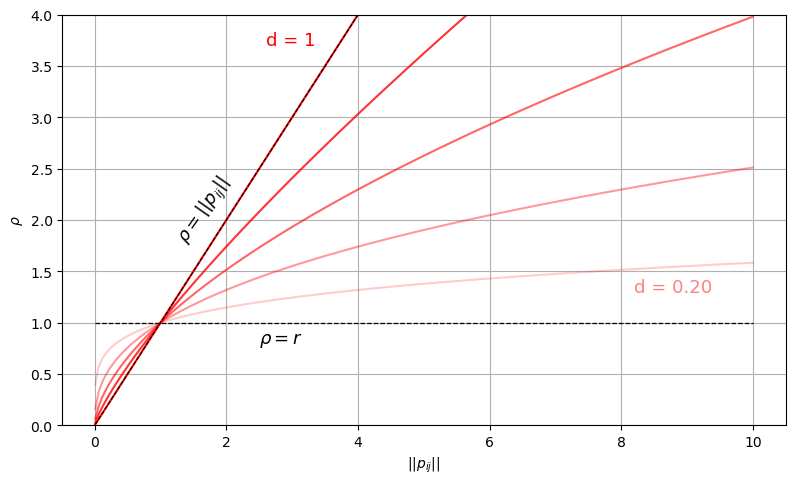

In [97]:
r = 1
d_list = [1, 0.8, 0.6, 0.4, 0.2]

# Rho equation
rho = lambda norm, d: ((norm)**(d)/r**(d-1))
#rho_neperian = lambda norm: r * (np.log(norm)**n2 + 1)**(1)

# - Visualization
figsize=np.array([14, 8])/1.5
dpi = 100

fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(1, 1, hspace=0.1, wspace=0.4)
ax  = fig.add_subplot(grid[:, :])

ax.set_xlabel(r"$||p_{ij}||$")
ax.set_ylabel(r"$\rho$")
ax.set_ylim([0,4])
ax.grid(True)

# Plot some rho functions candidates
norm = np.linspace(0.01, 10*r, 200)

for n in d_list:
    ax.plot(norm, rho(norm,n), "r", alpha=n)

# Furnitures
ft = 13
ax.text(2.6, 3.7, "d = {0:.0f}".format(d_list[0]), c="r", alpha=1, fontsize=ft)
ax.text(8.2, 1.3, "d = {0:.2f}".format(d_list[-1]), c="r", alpha=0.5, fontsize=ft)
ax.text(1.2, 1.8, r"$\rho = ||p_{ij}||$", c="k", rotation=55, fontsize=ft)
ax.text(2.5, 0.8, r"$\rho = r$", c="k", fontsize=ft)

ax.plot(norm, norm, "--k", lw=0.8)
ax.plot(norm, r*np.ones(200), "--k", lw=0.9)

plt.show()

---
## Video material
---

### Crash

In [177]:
arr_kw = {"width":0.003, "scale":14.3, "zorder":2}
scale = 1

px_lims = [-11,3.3]
py_lims = [-3,5]

# Parameters
col_rad = 1.2

rbt_xy = np.array([-6, 0])

phi0, dphi = np.pi/10, np.pi/10
rbt_phi = np.linspace(phi0, phi0 - dphi,100)
rbt_phi = np.append(rbt_phi, np.linspace(phi0 - dphi, phi0 + dphi, 200))
rbt_phi = np.append(rbt_phi, np.linspace(phi0 + dphi ,phi0, 100))

obs_xy = np.array([[1, -0.3], [-1.7, 2.5]])
obs_phi = np.array([0,0])

# Trajectory parameters
a, b, xoff = 20, 8, [3,-10]

# Anim parameters
tf = 20
dt = 20/400

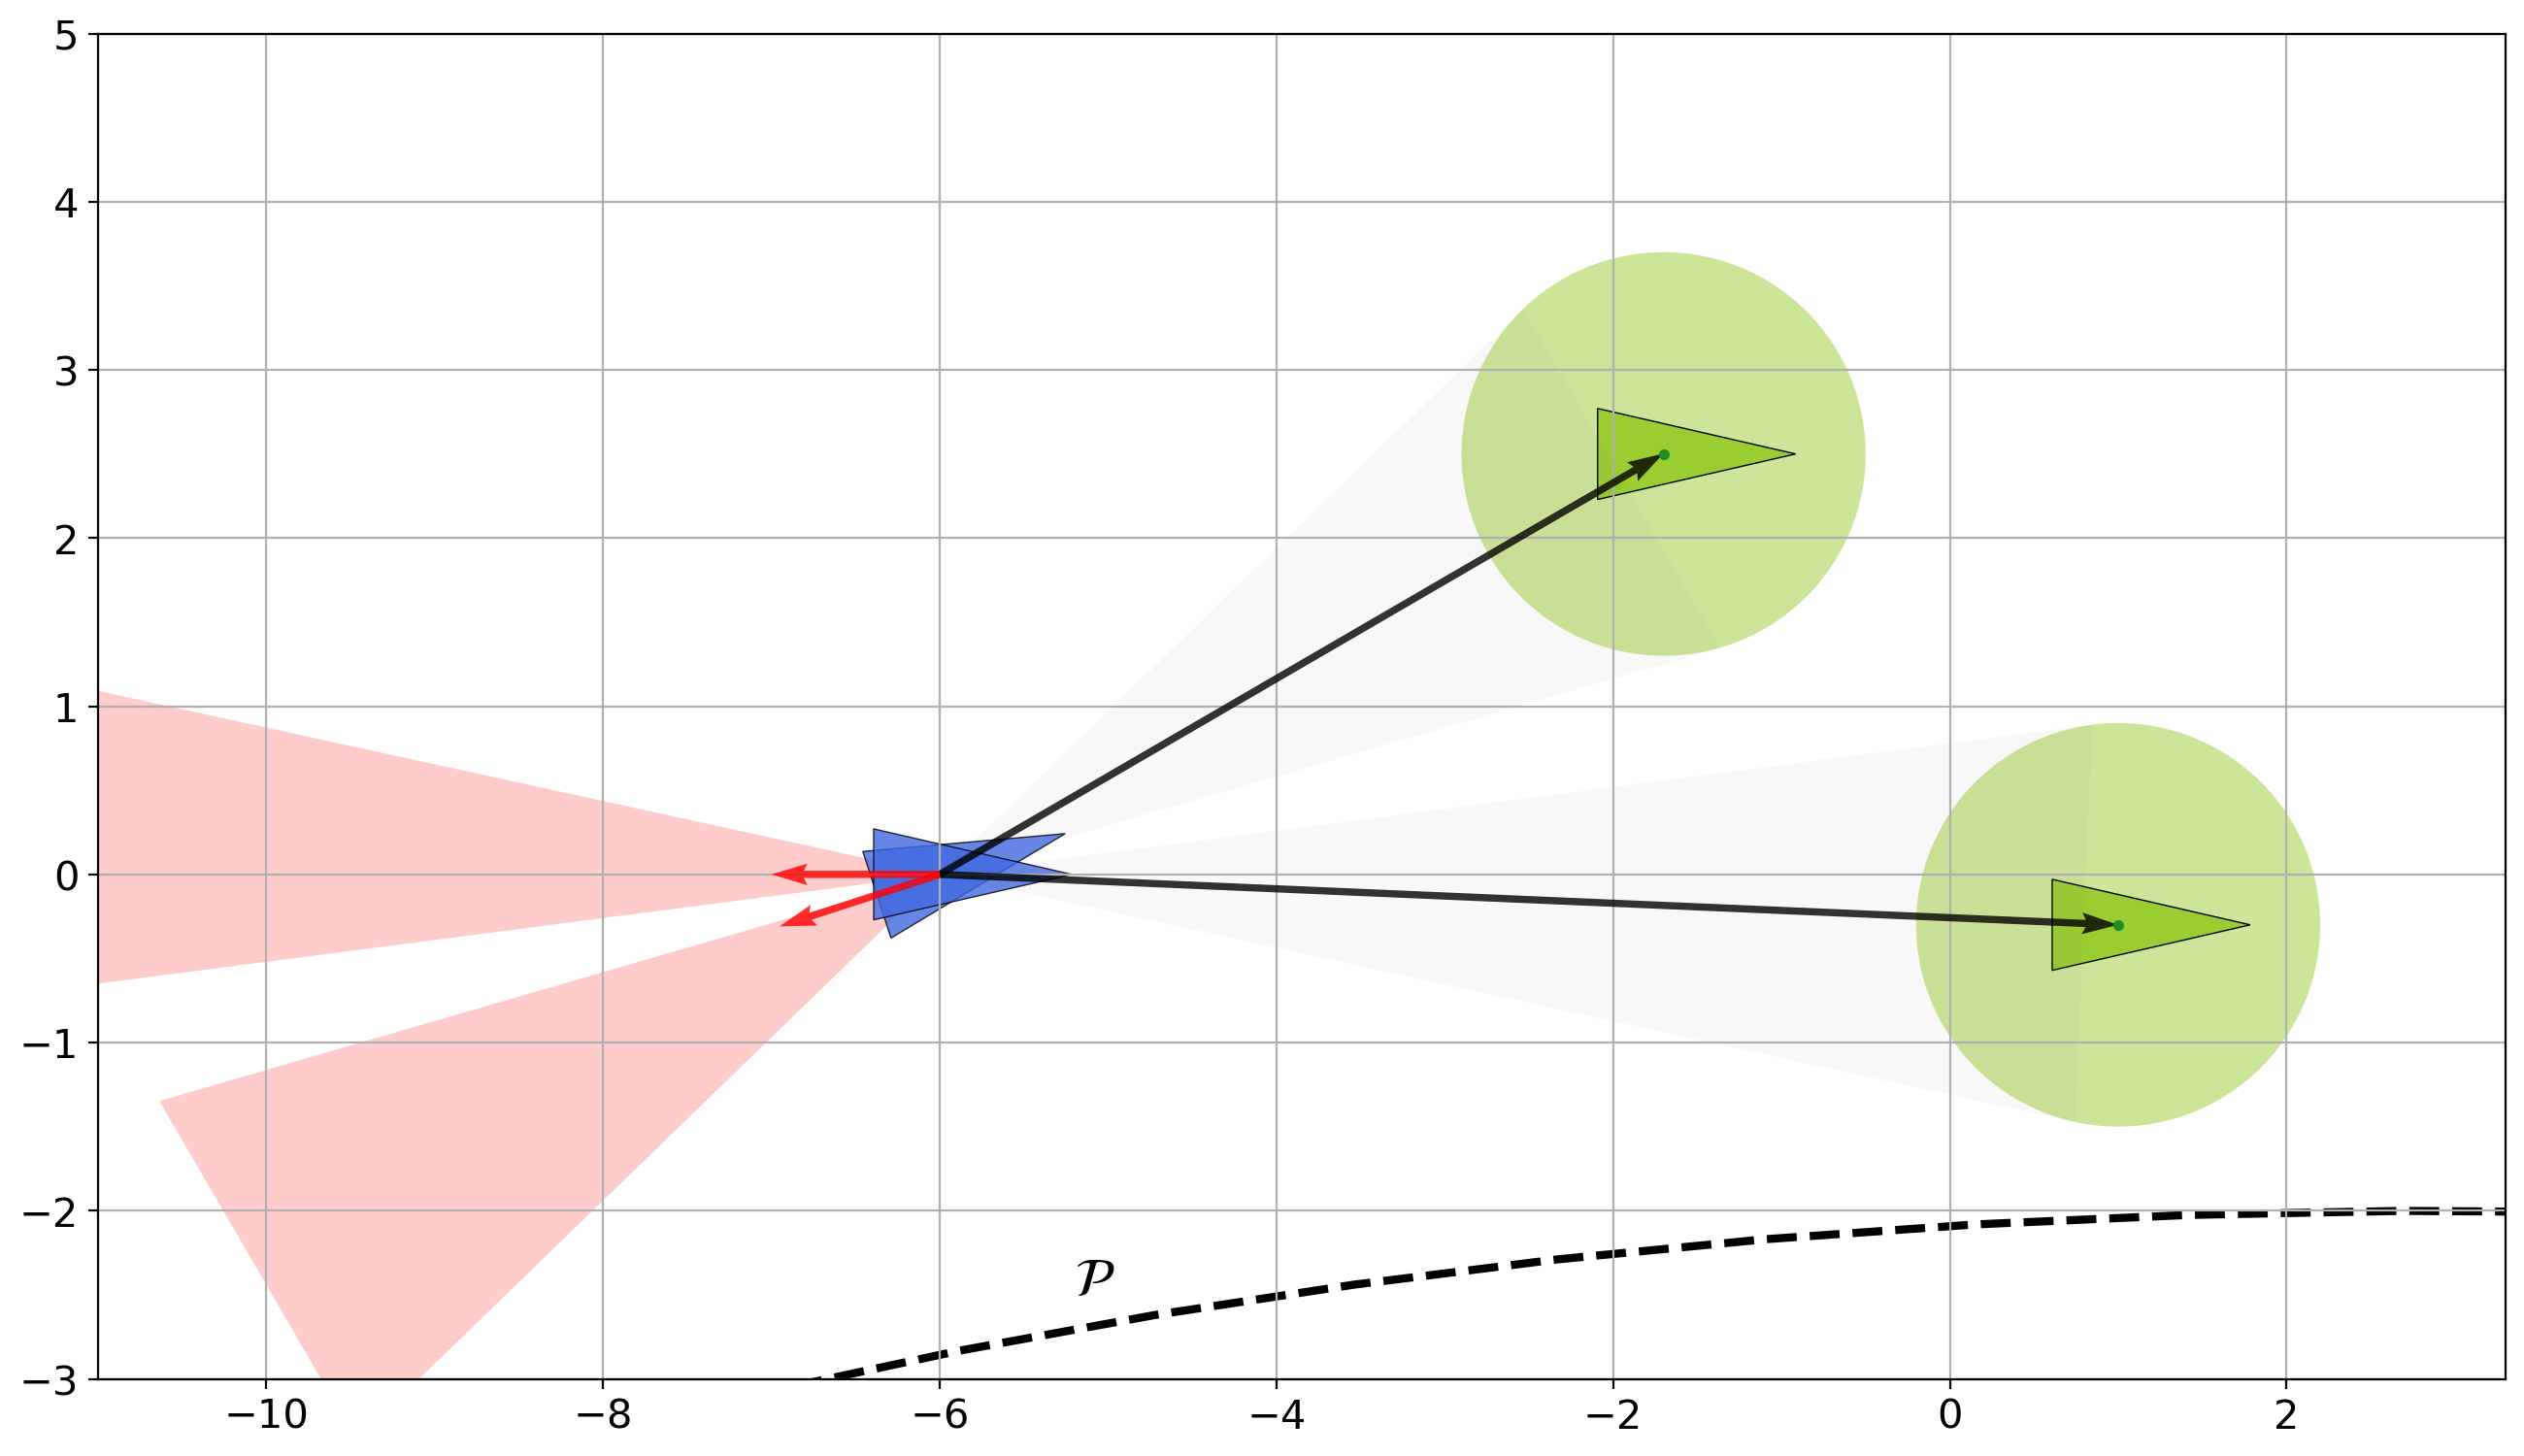

In [178]:
# ----------------------------
# C3BF - Crash plot
# ----------------------------

# Draw the obstacles
def draw_obs(ax, obs_xy, obs_phi, rbt_xy, r_col=1):
        icon_obs = unicycle_patch(obs_xy, obs_phi, "yellowgreen")
        icon_col_real = patches.Circle(obs_xy, r_col, alpha=0.5, fill=True,
                                color="yellowgreen", ls="", lw=2, zorder=-1)
        ax.add_patch(icon_obs)
        ax.add_patch(icon_col_real)

        # Draw the points
        ax.plot(obs_xy[0], obs_xy[1], ".", c="forestgreen", zorder=4)
        
        # Draw pij
        ax.quiver(rbt_xy[0], rbt_xy[1], obs_xy[0]-rbt_xy[0], obs_xy[1]-rbt_xy[1], color="k", **arr_kw, alpha=0.8)

def draw_cone(ax, obs_xy, rbt_xy, r_col=1):
        p_rel = obs_xy - rbt_xy

        # GRAY CONES
        p1, p2 = cone_params(obs_xy, r_col, rbt_xy)
        red_cone = patches.Polygon(np.array([rbt_xy, p1, p2]),
                                alpha=0.05, color="gray", zorder=1, lw=0)
        ax.add_patch(red_cone)

        # RED CONE
        p1, p2 = cone_params(obs_xy - 2*p_rel, r_col, rbt_xy)
        gray_cone = patches.Polygon(np.array([rbt_xy, p1, p2]),
                                alpha=0.2, color="red", zorder=1, lw=0)
        ax.add_patch(gray_cone)

def draw_robot(ax, rbt_xy, rbt_phi, i, scale=1, alpha=0.8):
        icon_rbt = unicycle_patch(rbt_xy, rbt_phi[i], "royalblue")
        icon_rbt.set_alpha(alpha)
        ax.add_patch(icon_rbt)

        ax.quiver(rbt_xy[0], rbt_xy[1], -np.cos(rbt_phi[i])*scale, -np.sin(rbt_phi[i])*scale, color="red", **arr_kw, alpha=alpha)

# Number of agents
n = obs_xy.shape[0]

# Trajectory (just to draw it)
gvf_traj = gvf_ellipse(xoff,0,a,b)

# ----------------------------------------------
# Inicialización y configuración de la figuras
fig = plt.figure(figsize = (16, 9), dpi = 200)
ax = fig.subplots()

ax.set_xlim(px_lims) ################
ax.set_ylim(py_lims) ############

ax.tick_params(axis='both', labelsize=15)
ax.grid(True)

# Draw the trajectory
gvf_traj.draw(fig, ax, draw_field=False, lw=3)

# Draw obstacles and col. cones
for i in range(n):
        draw_obs(ax, obs_xy[i,:], obs_phi[i], rbt_xy, col_rad)
        draw_cone(ax, obs_xy[i,:], rbt_xy, col_rad)

# ----
# Draw robot
draw_robot(ax, rbt_xy, rbt_phi, 0)
draw_robot(ax, rbt_xy, rbt_phi, 100)
# ----

# Draw the text boxes
ax.text(-5.2,-2.5, r"$\mathcal{P}$", c="k", fontsize=20)

# Plot
plt.show()


In [180]:
tf_anim = tf
fps = 1/dt
frames = int(tf_anim/dt-1)

print("Animation parameters: ", {"fps":fps, "tf":tf_anim/1000, "frames":frames})

#  ----------------------------------------------
# Inicialización y configuración de la figuras
fig = plt.figure(figsize = (16, 9), dpi = 1920/16)
ax = fig.subplots()

ax.set_xlim(px_lims)
ax.set_ylim(py_lims)

ax.tick_params(axis='both', labelsize=15)
ax.grid(True)

# Draw the trajectory
gvf_traj.draw(fig, ax, draw_field=False, lw=3)

# Draw obstacles and col. cones
for i in range(n):
        draw_obs(ax, obs_xy[i,:], obs_phi[i], rbt_xy, col_rad)
        draw_cone(ax, obs_xy[i,:], rbt_xy, col_rad)

# Draw robot
rbt_list = []
rbt_icon = unicycle_patch(rbt_xy, rbt_phi[i], "royalblue")
ax.add_patch(rbt_icon)
rbt_list.append(rbt_icon)

vij = ax.quiver(rbt_xy[0], rbt_xy[1], -np.cos(rbt_phi[i])*scale, -np.sin(rbt_phi[i])*scale, color="red", **arr_kw)

# Draw the text boxes
ax.text(-5.2,-2.5, r"$\mathcal{P}$", c="k", fontsize=20)

# -- Animation
def animate(i):
        # Robot icon
        rbt_list[0].remove()
        rbt_list[0] = unicycle_patch(rbt_xy, rbt_phi[i], "royalblue", size=1)
        rbt_list[0].set_zorder(-1)
        ax.add_patch(rbt_list[0])

        # Drawing vectors
        vij.set_UVC(-np.cos(rbt_phi[i]), -np.sin(rbt_phi[i]))

anim = FuncAnimation(fig, animate, frames=tqdm(range(frames), initial=1, position=0), interval=1/fps*1000)
plt.close()

HTML(anim.to_html5_video()) # It takes a looot of time...

Animation parameters:  {'fps': 20.0, 'tf': 0.02, 'frames': 399}


  0%|          | 1/399 [00:00<?, ?it/s]

100%|█████████▉| 398/399 [00:31<00:00, 12.31it/s]

100%|█████████▉| 398/399 [00:43<00:00, 12.31it/s]

---
## Testing zone
---

### Drawing the collision zone of the ellipse

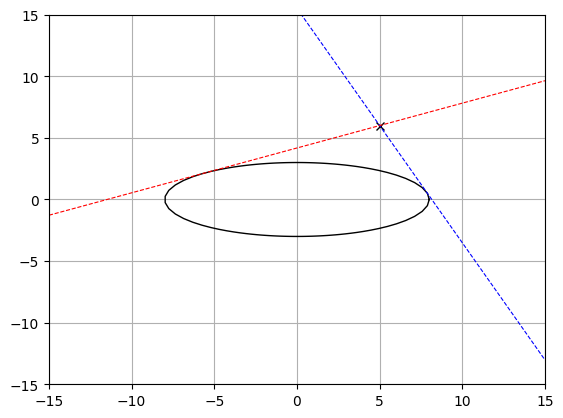

In [85]:
# Equation of the ellipse
a, b = 8, 3
r_ell = lambda t: a*b / np.sqrt((b*np.cos(t))**2 + (a*np.sin(t))**2) 

# Equation of tangent lines
y_tang1 = lambda x,m: m*x + np.sqrt(a**2*m**2 + b**2)
y_tang2 = lambda x,m: m*x - np.sqrt(a**2*m**2 + b**2)

# Compute m to find the tangent containing p
m1  = lambda x,y: (2*x*y + np.sqrt(4*x**2*y**2 - 4*(x**2 - a**2)*(y**2 - b**2)))/(2*(x**2 - a**2))
m2 = lambda x,y: (2*x*y - np.sqrt(4*x**2*y**2 - 4*(x**2 - a**2)*(y**2 - b**2)))/(2*(x**2 - a**2))

# Drawing ellipse and tangent lines to the point
x0, y0 = 5, 6 # robot position

t = np.linspace(0,2*np.pi,100)
r = r_ell(t)

x = np.linspace(-15,15,100)

if y0 > 0:
    y1 = y_tang1(x,m1(x0,y0))
    y2 = y_tang1(x,m2(x0,y0))
elif y0 == 0 and x0 > 0:
    y1 = y_tang2(x,m1(x0,y0))
    y2 = y_tang1(x,m2(x0,y0))
elif y0 == 0 and x0 < 0:
    y1 = y_tang1(x,m1(x0,y0))
    y2 = y_tang2(x,m2(x0,y0))
else:
    y1 = y_tang2(x,m1(x0,y0))
    y2 = y_tang2(x,m2(x0,y0))

plt.plot(r*np.cos(t), r*np.sin(t), "-k", lw=1)
plt.plot(x0, y0, "xk")
plt.plot(x, y1, "--b", lw=0.8)
plt.plot(x, y2, "--r", lw=0.8)

plt.xlim([-15,15])
plt.ylim([-15,15])
plt.grid(True)
plt.show()